# Anomality Detection Temperature IoT
Nov 10th 2023

In [44]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plotsize = (22, 5)
plt.rcParams['figure.figsize']= plotsize
# Pandas config
pd.options.display.float_format= '{:,.4f}'.format

## 1) Input data

In [23]:
data_path = "data/Temperature_1week.csv"
df = pd.read_csv(data_path, header=None, parse_dates= [0]).rename(columns={0: "time", 1:"temperature"})
df["temperature"] = df["temperature"].str.replace(" °C", "").astype(float)
df

,time,temperature
0,2023-11-03 17:00:00,22.2000
1,2023-11-03 17:05:00,22.3000
2,2023-11-03 17:10:00,22.5000
3,2023-11-03 17:15:00,22.5000
4,2023-11-03 17:20:00,22.6000
...,...,...
2012,2023-11-10 16:40:00,22.3000
2013,2023-11-10 16:45:00,22.3000
2014,2023-11-10 16:50:00,22.3000
2015,2023-11-10 16:55:00,22.3000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         2017 non-null   datetime64[ns]
 1   temperature  2017 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 31.6+ KB


## 2) EDA

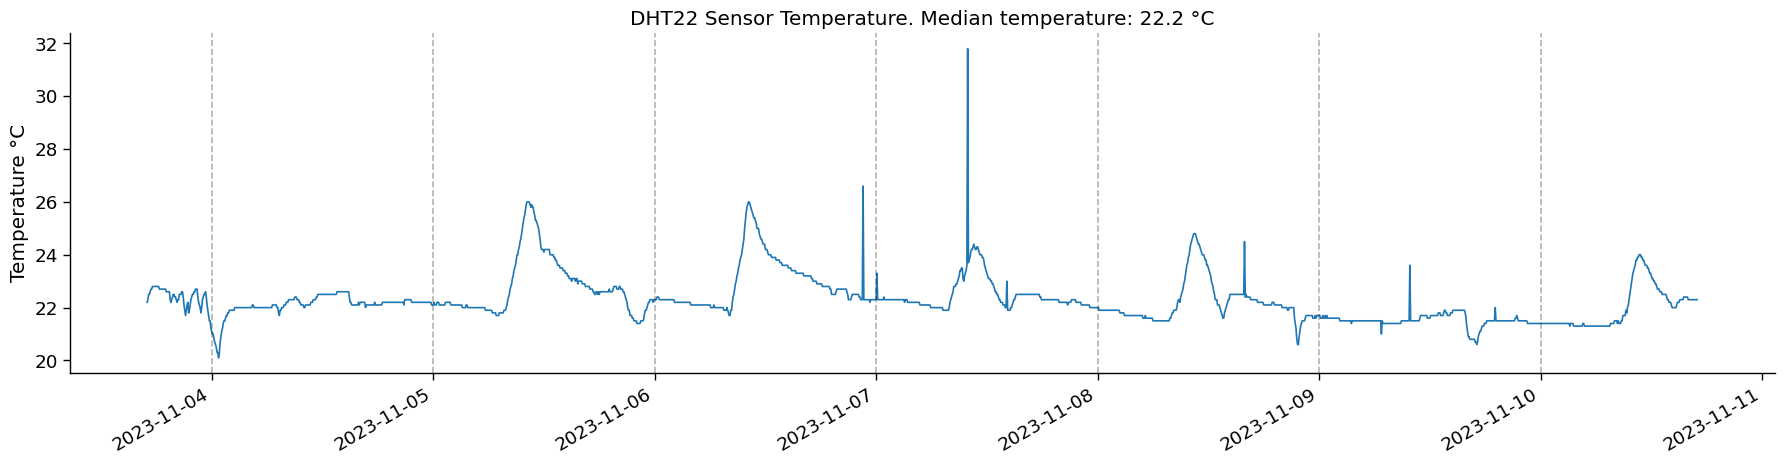

In [64]:
# Vars
median_temp = df["temperature"].median()
range_days = np.unique(np.array(df["time"], dtype="datetime64[D]")).astype(datetime)
range_days = range_days[1:len(range_days)]

# Plots
df.set_index(pd.to_datetime(df["time"]))["temperature"].plot()
for i  in range_days:
    plt.axvline(i, color='k', linestyle='--', alpha=0.3)
plt.xlabel("")
plt.title(f"DHT22 Sensor Temperature. Median temperature: {median_temp} °C")
plt.ylabel("Temperature °C")
plt.show()